In [1]:
!nvidia-smi

import os
from google.colab import drive

drive.mount('/content/gdrive')

work_root = "/content/gdrive/My Drive/cigarette_butt_segmentation"
%cd "$work_root"
data_root = '/content/data'
if not os.path.exists(data_root):
    !unzip data/cig_butts.zip -d $data_root
    !mv $data_root/cig_butts/* $data_root
    !rm -r $data_root/cig_butts 
out_dir = work_root + '/results'
weights_file_name_templ = out_dir + '/CigHeadWeights_Epoch%d.h5'

if 0:       # Warning: one-time operation, then the sources are supposed to be edited
    %cd /content
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.3.0

    target_dir = work_root + "/lib/detection"
    %mkdir "$target_dir"
    # # !cp references/detection/utils.py ../
    # # !cp references/detection/transforms.py ../
    # !cp references/detection/coco_eval.py "$work_root/lib/torchvision/"
    # !cp references/detection/engine.py "$work_root/lib/torchvision/"
    # # !cp references/detection/coco_utils.py ../
    !cp references/detection/*.py "$target_dir/"

    %cd $work_root

Sun Oct  4 11:19:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile
from glob import glob

from lib import *
from lib.net import *

# from lib.torchvision.transforms1 import get_transform
# from lib.torchvision import train
# from lib.torchvision import engine
# from lib.torchvision.utils import *

# %ls -l lib/detection/
import lib.detection.transforms
from lib.detection.transforms import get_transform
from lib.detection import train
from lib.detection import engine
from lib.detection.det_utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# import torchvision.models.segmentation as segmentation

# # model = segmentation.deeplabv3_resnet50(True, True, 2)
#     # Fails because it is pretrained on 21 classes

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 2  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
dataset = CigDataset(data_root + '/train', get_transform(train=True))
dataset_test = CigDataset(data_root + '/val', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# dataset[0]

2000 images
200 images


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes, True)
model.to(device)
# criterion = train.get_criterion()
epochNum = 0

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [9]:
# save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
# save_model_state(model, (weights_file_name_templ % epochNum) + '_full')   # 
epochNum = 34
load_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
load_model_state(model, (weights_file_name_templ % epochNum) + '_full')  

State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5 (<All keys matched successfully>)
State loaded from /content/gdrive/My Drive/cigarette_butt_segmentation/results/CigHeadWeights_Epoch34.h5_full (<All keys matched successfully>)


{}

In [8]:
num_epochs = 100

for epoch in range(num_epochs):
    train.train_one_epoch(model, optimizer, data_loader, device, epochNum, 
                          print_freq=10, printFunc=printProgress)
    # train.train_one_epoch(model, train.criterion, optimizer, data_loader, lr_scheduler, device,
    #                       epochNum, print_freq=10)
    # lr_scheduler.step()
    train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)    
    epochNum += 1
    if epochNum % 5 == 0:
        save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


KeyboardInterrupt: ignored

In [38]:
img_idxs = range(300)
model.eval()
with torch.no_grad():
    dices = []
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        maskCount = masks.shape[0]
        threshold = 0.7
        if maskCount != 0:
            dice = get_dice(target['masks'][0].numpy().astype(bool),
                            masks[0, 0].numpy() > threshold) / maskCount
                # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
        else:
            dice = 0
        dices.append(dice)
    dices = np.array(dices)
    sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (threshold, dices[sorted_dice_inds]))

In [39]:
print('Threshold %f dices: %s (%s)' % (threshold, dices[sorted_dice_inds], sorted_dice_inds))

Threshold 0.700000 dices: [0.46445825 0.47439495 0.48709868 0.92259821 0.9276241  0.93698919
 0.93802009 0.93864013 0.93936633 0.94039504 0.94323432 0.94373593
 0.94447275 0.94542091 0.94611096 0.94621335 0.94749745 0.94776589
 0.94830287 0.94871795 0.94893832 0.94932801 0.94936709 0.94949793
 0.94958968 0.95047053 0.95047706 0.95067129 0.95072464 0.95129325
 0.9518489  0.95195419 0.95196659 0.952207   0.95249795 0.95326606
 0.95345345 0.95368261 0.95371607 0.95374944 0.95384615 0.95394618
 0.95400341 0.95409541 0.9542029  0.95458117 0.95473646 0.95511222
 0.95514166 0.95534082 0.95550562 0.95552224 0.9555421  0.95558131
 0.95565322 0.95569719 0.95591771 0.95597484 0.95601336 0.95611285
 0.95658263 0.95660169 0.95669138 0.9567232  0.95687551 0.95710741
 0.95719582 0.95720008 0.95722194 0.95744681 0.95753846 0.95780774
 0.9579423  0.95801938 0.95814597 0.95828967 0.95837367 0.95846379
 0.95871433 0.95882115 0.95886776 0.95909786 0.95918007 0.95959326
 0.9596113  0.95961869 0.95989975 0.

In [50]:
img_idxs = range(200, 1200)  # sorted_dice_inds[:10]
rowCount = 1 # len(img_idxs)
colCount = 4
model.eval()
with torch.no_grad():
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        mask_count = masks.shape[0]
        cur_dices = []
        for threshold in [0.1, 0.3, 0.5, 0.7, 0.95]:
            if mask_count != 0:
                dice = get_dice(target['masks'][0].numpy().astype(bool),
                                masks[0, 0].numpy() > threshold) / maskCount
                    # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
            else:
                dice = 0
            cur_dices.append(dice)
        print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
              (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
        if cur_dices[2] > 0.95:
            continue

        plt.figure(figsize=(12, 8))        
        zero_mask = np.zeros(list(masks.shape[2:]))
        mask_sum = np.copy(zero_mask)        
        for mask_ind in range(min(colCount - 1, maskCount)):
            # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
            mask = masks[mask_ind, 0].numpy()
            where = np.where(mask > 0.5)
            # where = (where[0] , where[1] + 50)
            # mask[where] = 0.3
            target_where = np.where(target['masks'][0].numpy() > 0)
            # print('where', mask[where][:50])
            print('target bbox', target['boxes'])
            print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                  (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                   len(target_where[0])))
            # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
            mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
            mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)

            bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
            ax = plt.subplot(rowCount, colCount, mask_ind + 2)
                # For plots matrix - also img_idx2 * colCount + 
            im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            # plt.colorbar(im, ax=ax)
        # print(mask_sum.shape, target['masks'].shape)
        # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
        ax = plt.subplot(rowCount, colCount, 1)
        # im = ax.imshow(mask_sum)
        im = ax.imshow(np.transpose(img, (1, 2, 0)))

        # # Runs the entire evaluator on one image. But the results are non-visual
        # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
        # one_img_data_loader = torch.utils.data.DataLoader(
        #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
        #         collate_fn=collate_fn)
        # train.evaluate(model, one_img_data_loader, device=device)
        plt.show()
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Output hidden; open in https://colab.research.google.com to view.

Image 0 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.953, 0.969, 0.967, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 1 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.962, 0.975, 0.969, 0.897, masks: torch.Size([1, 1, 512, 512]), 1
Image 2 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.952, 0.959, 0.951, 0.878, masks: torch.Size([1, 1, 512, 512]), 1
Image 3 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.906, 0.938, 0.963, 0.981, 0.944, masks: torch.Size([2, 1, 512, 512]), 2
Image 4 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.949, 0.975, 0.981, 0.921, masks: torch.Size([1, 1, 512, 512]), 1
Image 5 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.967, 0.980, 0.958, 0.879, masks: torch.Size([1, 1, 512, 512]), 1
Image 6 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.927, 0.959, 0.976, 0.979, 0.926, masks: torch.Size([1, 1, 512, 512]), 1
Image 7 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.901, 0.927, 0.931, 0.932, 0.887, masks: torch.Size([1, 1, 512, 512]), 1


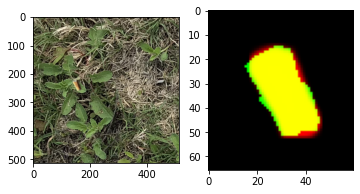

Image 8 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.945, 0.957, 0.955, 0.911, masks: torch.Size([1, 1, 512, 512]), 1
Image 9 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.943, 0.963, 0.957, 0.905, masks: torch.Size([1, 1, 512, 512]), 1
Image 10 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.952, 0.975, 0.976, 0.923, masks: torch.Size([1, 1, 512, 512]), 1
Image 11 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.920, 0.964, 0.981, 0.963, 0.885, masks: torch.Size([1, 1, 512, 512]), 1
Image 12 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.942, 0.970, 0.974, 0.948, masks: torch.Size([1, 1, 512, 512]), 1
Image 13 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.906, 0.957, 0.973, 0.950, 0.848, masks: torch.Size([1, 1, 512, 512]), 1
Image 14 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.914, 0.950, 0.963, 0.960, 0.904, masks: torch.Size([1, 1, 512, 512]), 1
Image 15 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.898, 0.940, 0.965, 0.966, 0.905, masks: torch.Size([1, 1, 512, 512

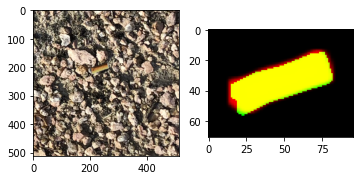

Image 17 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.944, 0.970, 0.980, 0.975, 0.940, masks: torch.Size([1, 1, 512, 512]), 1
Image 18 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.926, 0.943, 0.959, 0.969, 0.926, masks: torch.Size([1, 1, 512, 512]), 1
Image 19 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.945, 0.971, 0.981, 0.939, masks: torch.Size([1, 1, 512, 512]), 1
Image 20 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.955, 0.974, 0.971, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 21 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.898, 0.943, 0.961, 0.955, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 22 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.934, 0.970, 0.978, 0.957, 0.882, masks: torch.Size([1, 1, 512, 512]), 1
Image 23 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.852, 0.927, 0.958, 0.919, 0.728, masks: torch.Size([1, 1, 512, 512]), 1
Image 24 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.944, 0.958, 0.955, 0.910, masks: torch.Size([1, 1, 512, 5

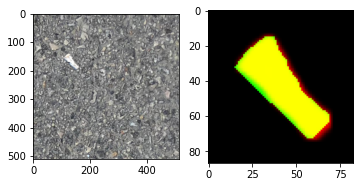

Image 35 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.884, 0.924, 0.954, 0.973, 0.938, masks: torch.Size([2, 1, 512, 512]), 2
Image 36 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.917, 0.951, 0.969, 0.973, 0.925, masks: torch.Size([1, 1, 512, 512]), 1
Image 37 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.908, 0.948, 0.970, 0.970, 0.899, masks: torch.Size([1, 1, 512, 512]), 1
Image 38 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.943, 0.958, 0.960, 0.943, 0.879, masks: torch.Size([1, 1, 512, 512]), 1
Image 39 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.908, 0.951, 0.973, 0.963, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 40 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.917, 0.950, 0.952, 0.945, 0.865, masks: torch.Size([1, 1, 512, 512]), 1
Image 41 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.955, 0.974, 0.966, 0.902, masks: torch.Size([1, 1, 512, 512]), 1
Image 42 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.959, 0.979, 0.959, 0.870, masks: torch.Size([1, 1, 512, 5

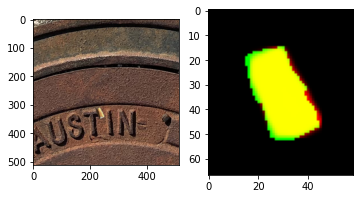

Image 51 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.899, 0.949, 0.976, 0.962, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 52 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.966, 0.976, 0.949, 0.862, masks: torch.Size([1, 1, 512, 512]), 1
Image 53 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.892, 0.941, 0.972, 0.970, 0.895, masks: torch.Size([1, 1, 512, 512]), 1
Image 54 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.950, 0.960, 0.959, 0.891, masks: torch.Size([1, 1, 512, 512]), 1
Image 55 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.965, 0.986, 0.971, 0.905, masks: torch.Size([1, 1, 512, 512]), 1
Image 56 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.954, 0.966, 0.947, 0.867, masks: torch.Size([1, 1, 512, 512]), 1
Image 57 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.924, 0.959, 0.979, 0.975, 0.914, masks: torch.Size([1, 1, 512, 512]), 1
Image 58 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.889, 0.935, 0.959, 0.931, 0.812, masks: torch.Size([1, 1, 512, 5

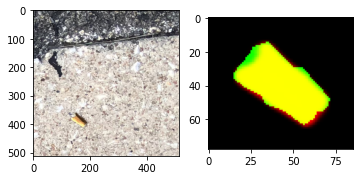

Image 77 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.952, 0.967, 0.955, 0.879, masks: torch.Size([1, 1, 512, 512]), 1
Image 78 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.963, 0.977, 0.974, 0.954, 0.915, masks: torch.Size([1, 1, 512, 512]), 1
Image 79 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.917, 0.943, 0.949, 0.963, 0.940, masks: torch.Size([1, 1, 512, 512]), 1
target bbox tensor([[324., 127., 373., 145.]])
Mask min 0.51, max 1.00, coords (332.0, 126.0), area 888, target area 869


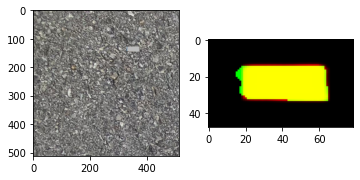

Image 80 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.955, 0.964, 0.962, 0.903, masks: torch.Size([1, 1, 512, 512]), 1
Image 81 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.952, 0.968, 0.973, 0.974, 0.930, masks: torch.Size([1, 1, 512, 512]), 1
Image 82 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.916, 0.959, 0.981, 0.967, 0.889, masks: torch.Size([1, 1, 512, 512]), 1
Image 83 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.907, 0.948, 0.974, 0.978, 0.916, masks: torch.Size([1, 1, 512, 512]), 1
Image 84 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.955, 0.977, 0.964, 0.890, masks: torch.Size([1, 1, 512, 512]), 1
Image 85 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.954, 0.968, 0.955, 0.870, masks: torch.Size([1, 1, 512, 512]), 1
Image 86 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.948, 0.973, 0.963, 0.887, masks: torch.Size([1, 1, 512, 512]), 1
Image 87 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.955, 0.959, 0.951, 0.891, masks: torch.Size([1, 1, 512, 5

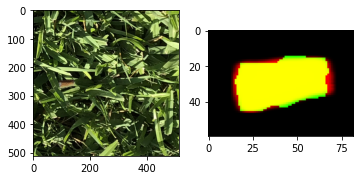

Image 132 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.964, 0.981, 0.969, 0.901, masks: torch.Size([1, 1, 512, 512]), 1
Image 133 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.944, 0.963, 0.973, 0.935, masks: torch.Size([1, 1, 512, 512]), 1
Image 134 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.000, 0.000, 0.000, 0.000, 0.000, masks: torch.Size([1, 1, 512, 512]), 1
target bbox tensor([[434., 415., 490., 438.]])
Mask min 0.50, max 1.00, coords (370.0, 287.0), area 3852, target area 1205


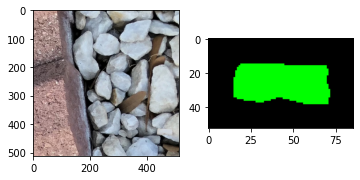

Image 135 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.915, 0.954, 0.963, 0.961, 0.900, masks: torch.Size([1, 1, 512, 512]), 1
Image 136 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.884, 0.941, 0.978, 0.949, 0.824, masks: torch.Size([1, 1, 512, 512]), 1
Image 137 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.950, 0.978, 0.967, 0.880, masks: torch.Size([1, 1, 512, 512]), 1
Image 138 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.924, 0.944, 0.958, 0.963, 0.928, masks: torch.Size([1, 1, 512, 512]), 1
Image 139 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.920, 0.949, 0.965, 0.964, 0.908, masks: torch.Size([1, 1, 512, 512]), 1
Image 140 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.912, 0.951, 0.970, 0.966, 0.894, masks: torch.Size([1, 1, 512, 512]), 1
Image 141 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.919, 0.951, 0.971, 0.971, 0.926, masks: torch.Size([1, 1, 512, 512]), 1
Image 142 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.920, 0.953, 0.968, 0.969, 0.939, masks: torch.Size([1, 1

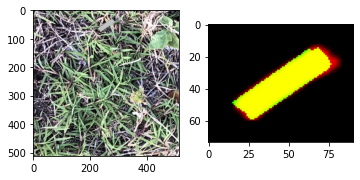

Image 157 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.904, 0.933, 0.956, 0.968, 0.924, masks: torch.Size([1, 1, 512, 512]), 1
Image 158 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.918, 0.958, 0.971, 0.954, 0.878, masks: torch.Size([1, 1, 512, 512]), 1
Image 159 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.895, 0.937, 0.959, 0.966, 0.911, masks: torch.Size([1, 1, 512, 512]), 1
Image 160 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.889, 0.947, 0.965, 0.947, 0.864, masks: torch.Size([1, 1, 512, 512]), 1
Image 161 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.918, 0.953, 0.969, 0.965, 0.899, masks: torch.Size([1, 1, 512, 512]), 1
Image 162 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.925, 0.960, 0.975, 0.958, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 163 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.896, 0.939, 0.951, 0.936, 0.866, masks: torch.Size([1, 1, 512, 512]), 1
Image 164 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.897, 0.947, 0.977, 0.967, 0.884, masks: torch.Size([1, 1

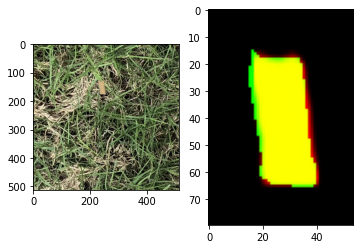

Image 168 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.909, 0.950, 0.972, 0.963, 0.886, masks: torch.Size([1, 1, 512, 512]), 1
Image 169 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.910, 0.958, 0.982, 0.965, 0.874, masks: torch.Size([1, 1, 512, 512]), 1
Image 170 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.923, 0.958, 0.973, 0.963, 0.905, masks: torch.Size([1, 1, 512, 512]), 1
Image 171 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.955, 0.973, 0.960, 0.878, masks: torch.Size([1, 1, 512, 512]), 1
Image 172 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.886, 0.940, 0.966, 0.944, 0.829, masks: torch.Size([1, 1, 512, 512]), 1
Image 173 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.911, 0.955, 0.975, 0.965, 0.889, masks: torch.Size([1, 1, 512, 512]), 1
Image 174 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.936, 0.961, 0.964, 0.945, 0.867, masks: torch.Size([1, 1, 512, 512]), 1
Image 175 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.870, 0.915, 0.937, 0.945, 0.916, masks: torch.Size([1, 1

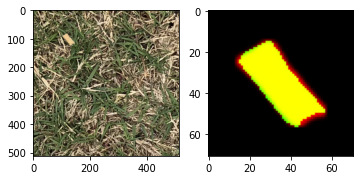

Image 176 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.902, 0.947, 0.975, 0.965, 0.888, masks: torch.Size([1, 1, 512, 512]), 1
Image 177 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.930, 0.963, 0.978, 0.968, 0.903, masks: torch.Size([1, 1, 512, 512]), 1
Image 178 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.903, 0.937, 0.948, 0.942, 0.893, masks: torch.Size([1, 1, 512, 512]), 1
target bbox tensor([[314., 150., 386., 188.]])
Mask min 0.50, max 1.00, coords (320.0, 150.0), area 1369, target area 1335


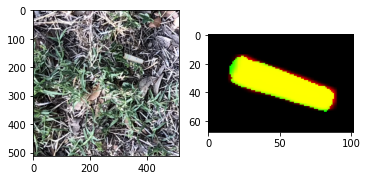

Image 179 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.900, 0.951, 0.966, 0.954, 0.877, masks: torch.Size([1, 1, 512, 512]), 1
Image 180 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.932, 0.961, 0.974, 0.969, 0.914, masks: torch.Size([1, 1, 512, 512]), 1
Image 181 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.893, 0.944, 0.954, 0.926, 0.796, masks: torch.Size([2, 1, 512, 512]), 2
Image 182 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.918, 0.948, 0.963, 0.967, 0.912, masks: torch.Size([1, 1, 512, 512]), 1
Image 183 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.924, 0.957, 0.976, 0.971, 0.912, masks: torch.Size([1, 1, 512, 512]), 1
Image 184 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.913, 0.949, 0.967, 0.979, 0.940, masks: torch.Size([1, 1, 512, 512]), 1
Image 185 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.921, 0.956, 0.969, 0.972, 0.920, masks: torch.Size([1, 1, 512, 512]), 1
Image 186 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: 0.921, 0.947, 0.966, 0.965, 0.897, masks: torch.Size([1, 1

In [51]:
img_idxs = range(200)  # sorted_dice_inds[:10]
rowCount = 1 # len(img_idxs)
colCount = 4
model.eval()
with torch.no_grad():
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset_test[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        mask_count = masks.shape[0]
        cur_dices = []
        for threshold in [0.1, 0.3, 0.5, 0.7, 0.95]:
            if mask_count != 0:
                dice = get_dice(target['masks'][0].numpy().astype(bool),
                                masks[0, 0].numpy() > threshold) / maskCount
                    # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
            else:
                dice = 0
            cur_dices.append(dice)
        print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
              (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
        if cur_dices[2] > 0.95:
            continue

        plt.figure(figsize=(12, 8))        
        zero_mask = np.zeros(list(masks.shape[2:]))
        mask_sum = np.copy(zero_mask)        
        for mask_ind in range(min(colCount - 1, maskCount)):
            # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
            mask = masks[mask_ind, 0].numpy()
            where = np.where(mask > 0.5)
            # where = (where[0] , where[1] + 50)
            # mask[where] = 0.3
            target_where = np.where(target['masks'][0].numpy() > 0)
            # print('where', mask[where][:50])
            print('target bbox', target['boxes'])
            print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                  (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                   len(target_where[0])))
            # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
            mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
            mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)

            bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
            ax = plt.subplot(rowCount, colCount, mask_ind + 2)
                # For plots matrix - also img_idx2 * colCount + 
            im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            # plt.colorbar(im, ax=ax)
        # print(mask_sum.shape, target['masks'].shape)
        # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
        ax = plt.subplot(rowCount, colCount, 1)
        # im = ax.imshow(mask_sum)
        im = ax.imshow(np.transpose(img, (1, 2, 0)))
        plt.show()

# Данные, метрики и доступные функции

Посмотрим на данные:

In [ ]:
def show_images(data_path, img_ids):
    images = os.listdir(f"{data_path}/images")
    annotations = json.load(open(f"{data_path}/coco_annotations.json", "r"))
    for img_id in img_ids:
        img = None
        for ext in ['png', 'jpg', 'jpeg', 'gif']:
            img_path = f"{data_path}/images/{img_id:08}.{ext}"
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
        mask = utils.get_mask(img_id, annotations)  # [130:170, 270:350]
        show.show_img_with_mask(img, mask)
    return mask
    
mask = show_images(f"{data_root}/val", [3, 5])      # A couple of strange val. images

Пример подсчета метрики:

In [ ]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask), np.sum((mask > 0).astype(int)) / mask.size

// Можно для последовательности масок вычислить среднее значение метрики


Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [ ]:
rle_mask = encode_rle(mask)
rle_mask

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [ ]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [ ]:
val_annotations = json.load(open(f"{data_root}/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob(f"{data_root}/val/images/*"))
paths_to_imgs = paths_to_imgs[:10]
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

path_to_save = "results/example"
# generate_images_for_html(paths_to_imgs, masks, path_to_save=path_to_save)     
# generate_html(path_to_save, 10)

masks[0]

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.